## **1. Introduction**
Our project is concerned with implementing a generative adversarial network that takes black and white images as input and the output obtains a corresponding coloured image. We use a special type of GAN called Conditional Generative Adversarial Network which takes a specific type of input rather than taking vectors from the random probability distribution. The GAN that we have implemented takes images (with one channel) of fixed size as input ( 32X32pixels) and the output obtained has the same size as the former. The images that can be efficiently coloured do not belong to a particular class of object but an array of things to choose from such as animals, vehicles, scenarios, etc. 

#### **1.1 Objective**
The main objective of this project is to colour fixed-size black and white images of any object, in general, using generative adversarial networks. The solution to this problem statement can be used for automating applications which require determining or enhancing the aesthetic look of something. For instance, UI developers need to determine the colour combinations that appeal to users.

## **2. Generative Adversarial Networks**

GAN is a generative algorithm introduced by Ian Goodfellow And Other Researchers in 2014. GAN tries to mimic the distribution of input dataset and accordingly generate new samples from the learnt distribution. GAN is analogous to a game between two players, where one player tries to produce fake notes and the other player tries to distinguish between real and fake notes. GAN is said to be trained well enough when one player generates fake notes that are good enough to fool the other player to believe that generated notes are real. 

#### **2.1 Architecture**
Two smaller networks, namely generator and discriminator constitute a generative adversarial network. The task of the generator as mentioned earlier is to produce an output that is indistinguishable from real data. The task of the discriminator, on the other hand is to classify whether a sample came from real data or is fake i.e generated by generator. Architecture Of both generator and discriminator is generally a multilayer perceptron model.


![Screenshot_5.jpg](https://production-media.paperswithcode.com/methods/gan.jpeg)



Fig. 1 GAN architecture


**2.2 Working** \
Generator tries to fool discriminator by generating data instances closest to the input dataset. Thus G tries to maximize the probability of D making a mistake. The discriminator tries to identify counterfeit data instances produced by the generator. This framework corresponds to a minimax two-player game(One for maximizing the probabilities for the real images and another for minimizing the probability of fake images). 

## **3. Code**

#### **3.1. Downloading and Processing the data**

A dataset of RGB images to train the GAN model whose images consists of various scenes/places.

* Download the dataset on your machine from [here](https://drive.google.com/file/d/12g9_MKh81MyEpcokeDvycNxu9iP1BLwr/view?usp=sharing). 
* Upload the downloaded `.zip` file here on Colab.


We'll now parse the images ( RGB images to be precise ) one by one, and transform each one to a grayscale image using PIL's `.convert( 'L' )` method. So our dataset will have samples of $( \ grayscale \ image \ , \ RGB \ image \ )$

We used only a part of our dataset, determined by `dataset_split` , as Colab's computational power would cease on providing a large number of images.



In [ ]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np

from tensorflow import keras

from sklearn.model_selection import train_test_split

from matplotlib import image
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/dataset.zip"

In [ ]:
batch_size = 32

img_size = 120

dataset_split = 2500

master_dir = 'data'
x = []
y = []
for image_file in os.listdir( master_dir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )

    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )

    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255

    x.append( gray_img_array )
    y.append( rgb_img_array )

train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )


#### **3.2. The GAN**

In this section, we'll create our GAN model step-by-step with Keras. First, we'll implement the generator then the discriminator and finally the loss functions required by both of them.


**3.2.1. Generator**

Our generator ( represented as $G$ ) will take in grayscale image $x$ and produce a RGB image $G( x )$. Note, $x$ will be a tensor of shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 1 \ )$ and the output $G(x)$ will have a shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 3 \ )$

* Our generator will have a encoder-decoder structure, similar to the UNet architecture. Additionally, we use Dilated convolutions to have a larger receptive field.

* We introduce skip connections in our model so as to have better flow of information from the encoder to the decoder.


![an image](https://nchlis.github.io/2019_10_30/architecture_unetV2.png)

Fig 2. A Standard UNet Structure

In [ ]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )

    return model

**3.2.2. Discriminator**

The discriminator model, represented as $D$, will take in the *real image* $y$ ( from the training data ) and the *generated image* $G(x)$ ( from the generator ) to output two probabilities.

* We train the discriminator in such a manner that is able to differentiate the *real images* and the generated *images*. So, we train the model such that $y$ produces a output of $1.0$ and $G(x)$ produces an output of $0.0$.
* Note that instead of using hard labels like $1.0$ and $0.0$, we use soft labels which are close to 1 and 0. So for a hard label of $1.0$, the soft label will be $(1 - \epsilon)$ where $\epsilon$ is picked uniformly from $( 0 , 0.1 ]$


In [ ]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]

    model = tf.keras.models.Sequential( layers )
    
    return model

**3.2.3. Loss Functions**

We'll now implement the loss functions for our GAN model. As you might know that we have two loss functions, one for the generator and another for the discriminator. 

* For our generator, we'll use the L2/MSE loss function.
* For optimization, we use the Adam optimizer with a learning rate of 0.0005



**3.2.4 Using Cross Entropy**

* If we have two separate probability distributions $p(X)$ and $q(X)$ over the same random variable $X$, we can measure how different these two distributions are using the Kullback-Leibler (KL) divergence:
<br />

$$D_{KL}(p \parallel q) = \sum\limits_{x \sim \mathcal{X}}p(x) \left[\text{log } \frac{p(x)}{q(x)} \right] = \sum\limits_{{x \sim \mathcal{X}}} p(x) \left[ \text{log }p(x) - \text{log } q(x) \right]$$.
<br />


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


#### **3.3. Training The GAN**


In [ ]:
@tf.function
def train_step(input_x , real_y):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator( input_x , training=True)

        real_output = discriminator( real_y, training=True)

        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss( generated_images , real_y )

        disc_loss = discriminator_loss( real_output, generated_output )
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

#### **3.4. Model Summary**

In [ ]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 116, 116, 16  416         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 116, 116, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 114, 114, 32)      4736      
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 32)      50208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 32)       0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        51264     
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                    

#### **3.5. Saving the Model weights**

The progress had to saved constantly to make sure the training can be restarted if the model stops taining for any reason.

If the training is being donw for the first times then the `load_model` is set to `False`.

In [ ]:
load_model = True

In [ ]:
if(load_model == True):
    generator.load_weights("/content/drive/MyDrive/Colab Notebooks/CV Project Saves/Generator.h5")
    discriminator.load_weights("/content/drive/MyDrive/Colab Notebooks/CV Project Saves/Discriminator.h5")

In [ ]:
num_epochs = 10
gen_losses = []
disc_losses = []

for e in tqdm(range(num_epochs)):
    for (x, y) in dataset:
        gen_loss, disc_loss = train_step(x, y)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

generator.save_weights("/content/drive/MyDrive/Colab Notebooks/CV Project Saves/Generator.h5")
discriminator.save_weights("/content/drive/MyDrive/Colab Notebooks/CV Project Saves/Discriminator.h5")

  0%|          | 0/10 [00:00<?, ?it/s]

## **4. Results**

We plotted the input, output and the original images respectively, from a part of the dataset to find out the results.


In [ ]:
y = generator(test_x[0:50]).numpy()

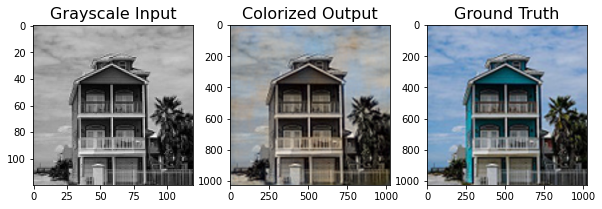

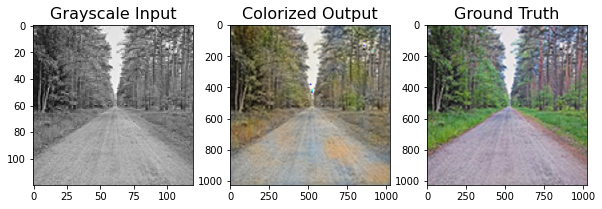

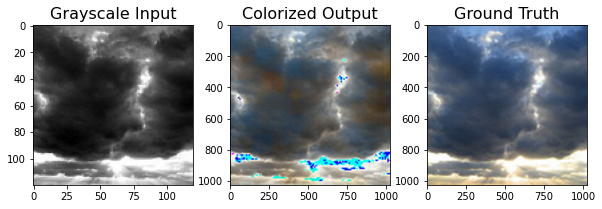

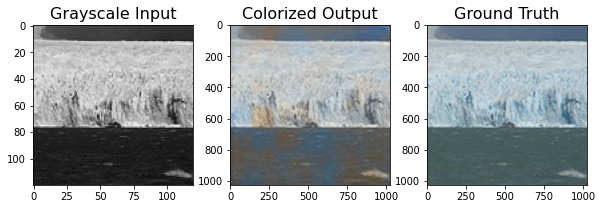

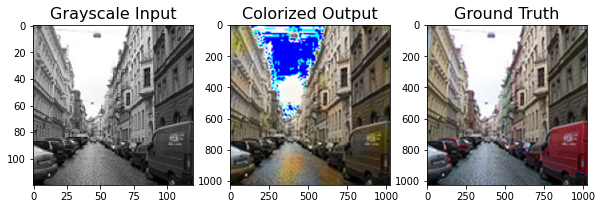

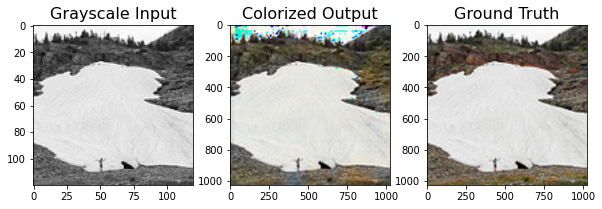

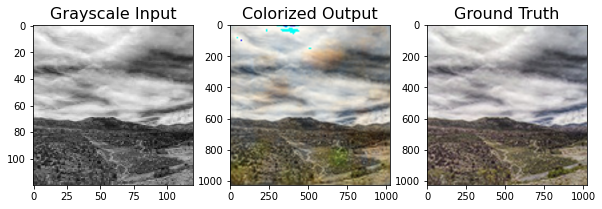

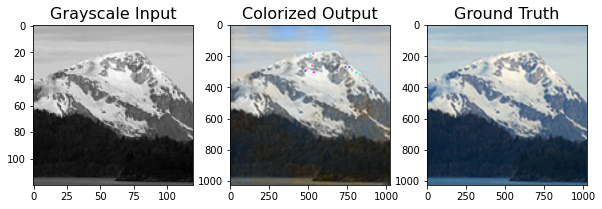

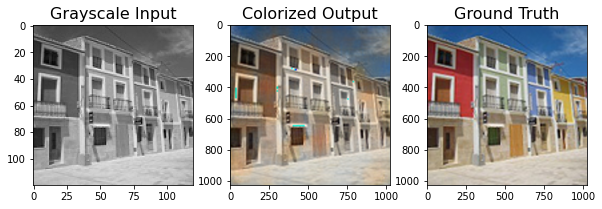

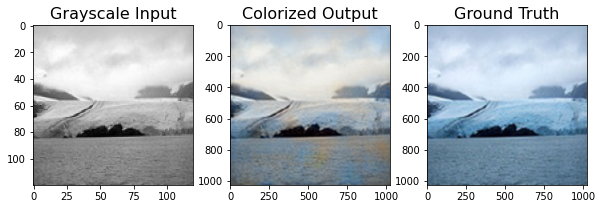

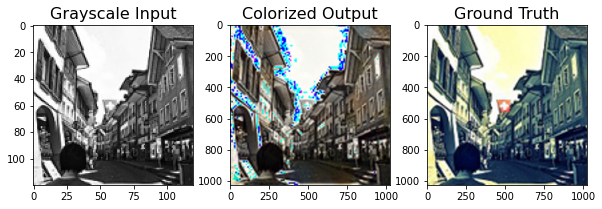

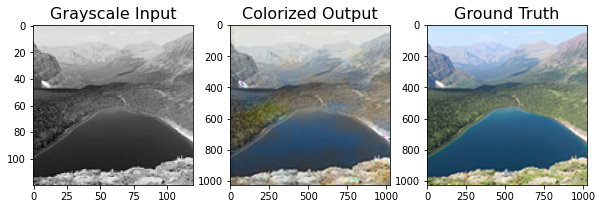

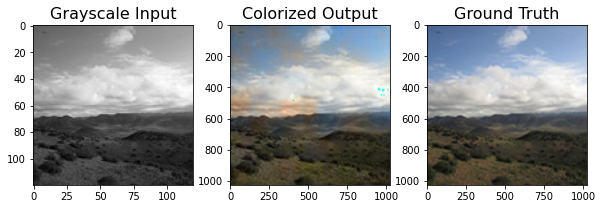

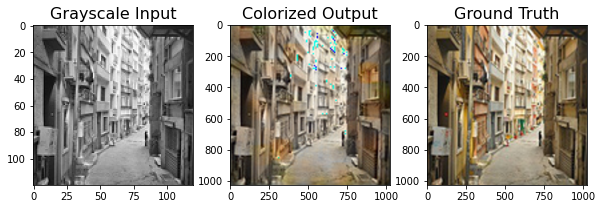

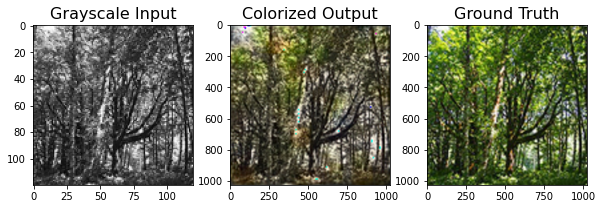

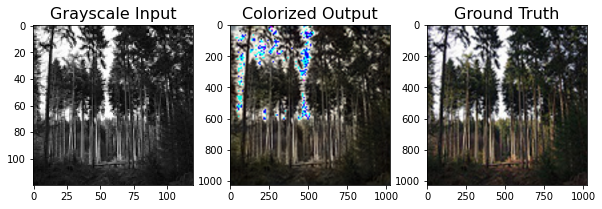

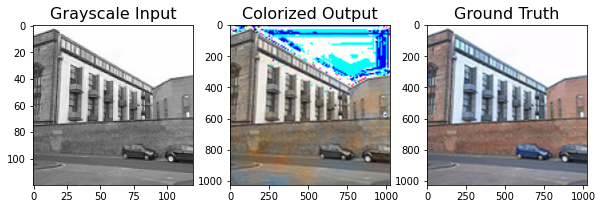

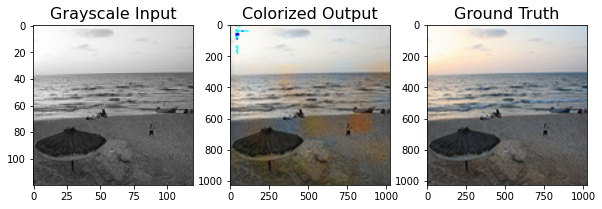

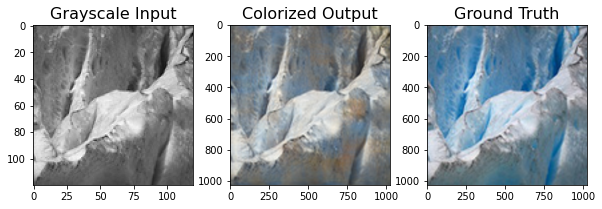

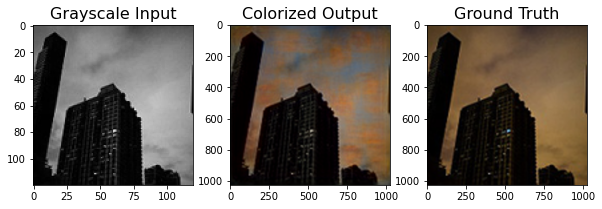

In [ ]:
for i in range(20):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow(test_x[i].reshape((120,120)) , cmap='gray')

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray((y[i] * 255).astype('uint8') ).resize((1024, 1024))
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( (test_y[i] * 255).astype('uint8')).resize((1024, 1024))
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow(image)

  plt.show()

## **5. Results**

Our project involved the use of conditional GAN for colourization black and white images. While implementing our project, we realized that architecture of a neural network as well as careful selection of hyperparameters act as a bottleneck to any deep learning project’s success. We Realized that even minor changes in such aspects of GAN can massively influence performance of GAN or any neural network in general.